In [1]:
import os
from skimage import io
from skimage import exposure
from skimage import transform

x_train = []
y_train = []
path = "../Data/gtsrb-german-traffic-sign/Train/"

for folder in os.listdir(path):
    class_path = path + folder + "/" 
    for image_name in os.listdir(class_path):
        image = io.imread(class_path + image_name)
        image = transform.resize(image, (32, 32))
        image = exposure.equalize_adapthist(image, clip_limit=0.1)
        
        x_train.append(image)
        y_train.append(int(folder))

C:\ProgramData\Anaconda3\lib\site-packages\skimage\util\dtype.py:135: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


In [2]:
import pandas as pd

test_df = pd.read_csv('../Data/gtsrb-german-traffic-sign/Test.csv')
test_df.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,53,54,6,5,48,49,16,Test/00000.png
1,42,45,5,5,36,40,1,Test/00001.png
2,48,52,6,6,43,47,38,Test/00002.png
3,27,29,5,5,22,24,33,Test/00003.png
4,60,57,5,5,55,52,11,Test/00004.png


In [3]:
x_test = []
y_test = []

test_imgs = test_df['Path'].values
labels = test_df['ClassId'].values
test_path = "../Data/gtsrb-german-traffic-sign/"

for image_name, label in zip(test_imgs, labels):
    image = io.imread(test_path + image_name)
    image = transform.resize(image, (32, 32))
    image = exposure.equalize_adapthist(image, clip_limit=0.1)
    x_test.append(image)
    y_test.append(int(label))

C:\ProgramData\Anaconda3\lib\site-packages\skimage\util\dtype.py:135: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


In [4]:
import numpy as np

x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [6]:
from tensorflow.keras.utils import to_categorical

num_labels = len(np.unique(y_train))
y_train = to_categorical(y_train, num_labels)
y_test = to_categorical(y_test, num_labels)

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

aug = ImageDataGenerator(
    rotation_range=10, 
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode="nearest")

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dense

input_shape = (32, 32, 3)
chan_dim = -1

model = Sequential()
model.add(Conv2D(8, (5, 5), padding="same", input_shape=input_shape))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chan_dim))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(16, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chan_dim))

model.add(Conv2D(16, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chan_dim))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chan_dim))

model.add(Conv2D(32, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chan_dim))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(128))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(128))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(num_labels))
model.add(Activation("softmax"))

In [11]:
from tensorflow.keras.optimizers import Adam

epochs = 15
batch_size = 64
initial_learning_rate = 1e-3

opt = Adam(lr=initial_learning_rate, decay=initial_learning_rate / (epochs * 0.5))
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 8)         608       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 8)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 8)         32        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 16)        1168      
_________________________________________________________________
activation_1 (Activation)    (None, 16, 16, 16)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 16)        6

In [12]:
class_totals = y_train.sum(axis=0)
class_weight = class_totals.max() / class_totals
class_weight

array([10.714286 ,  1.0135136,  1.       ,  1.5957447,  1.1363636,
        1.2096775,  5.357143 ,  1.5625   ,  1.5957447,  1.5306122,
        1.119403 ,  1.7045455,  1.0714285,  1.0416666,  2.8846154,
        3.5714285,  5.357143 ,  2.0270271,  1.875    , 10.714286 ,
        6.25     ,  6.818182 ,  5.769231 ,  4.4117646,  8.333333 ,
        1.5      ,  3.75     ,  9.375    ,  4.1666665,  8.333333 ,
        5.       ,  2.8846154,  9.375    ,  3.2656024,  5.357143 ,
        1.875    ,  5.769231 , 10.714286 ,  1.0869565,  7.5      ,
        6.25     ,  9.375    ,  9.375    ], dtype=float32)

In [13]:
from tensorflow.keras.callbacks import ModelCheckpoint

check_point_save = ModelCheckpoint('../Data/gtsrb-german-traffic-sign/best.h5', save_best_only=True, 
                                   monitor='val_loss', mode='min')

h = model.fit_generator(aug.flow(x_train, y_train, batch_size=batch_size), validation_data=(x_test, y_test), 
                        steps_per_epoch=x_train.shape[0] // batch_size, epochs=epochs, class_weight=class_weight, 
                        callbacks=[check_point_save], verbose=1)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
Train for 612 steps, validate on 12630 samples
Epoch 1/15
612/612 [==============================] - 114s 186ms/step - loss: 2.5819 - accuracy: 0.3159 - val_loss: 1.1841 - val_accuracy: 0.6223
Epoch 2/15
612/612 [==============================] - 152s 248ms/step - loss: 1.3226 - accuracy: 0.5827 - val_loss: 0.6752 - val_accuracy: 0.7858
Epoch 3/15
612/612 [==============================] - 75s 123ms/step - loss: 0.9015 - accuracy: 0.7088 - val_loss: 0.4542 - val_accuracy: 0.8625
Epoch 4/15
612/612 [==============================] - 63s 103ms/step - loss: 0.6703 - accuracy: 0.7820 - val_loss: 0.4064 - val_accuracy: 0.8764
Epoch 5/15
612/612 [==============================] - 57s 93ms/step - loss: 0.5376 - accuracy: 0.8276 - val_loss: 0.4278 - val_accuracy: 0.8748
Epoch 6/15
612/612 [==============================] - 56s 91ms/step - loss: 0.4416 - accuracy: 0.8580 - val_loss: 0.3072 - val

In [14]:
from tensorflow.keras.models import load_model

model = load_model('../Data/gtsrb-german-traffic-sign/best.h5')

In [15]:
label_names = pd.read_csv('../Data/gtsrb-german-traffic-sign/SignNames.csv')
label_names.head()

,ClassId,SignName
0,0,Speed limit (20km/h)
1,1,Speed limit (30km/h)
2,2,Speed limit (50km/h)
3,3,Speed limit (60km/h)
4,4,Speed limit (70km/h)


In [16]:
label_names = label_names['SignName'].values
label_names

array(['Speed limit (20km/h)', 'Speed limit (30km/h)',
       'Speed limit (50km/h)', 'Speed limit (60km/h)',
       'Speed limit (70km/h)', 'Speed limit (80km/h)',
       'End of speed limit (80km/h)', 'Speed limit (100km/h)',
       'Speed limit (120km/h)', 'No passing',
       'No passing for vehicles over 3.5 metric tons',
       'Right-of-way at the next intersection', 'Priority road', 'Yield',
       'Stop', 'No vehicles', 'Vehicles over 3.5 metric tons prohibited',
       'No entry', 'General caution', 'Dangerous curve to the left',
       'Dangerous curve to the right', 'Double curve', 'Bumpy road',
       'Slippery road', 'Road narrows on the right', 'Road work',
       'Traffic signals', 'Pedestrians', 'Children crossing',
       'Bicycles crossing', 'Beware of ice/snow', 'Wild animals crossing',
       'End of all speed and passing limits', 'Turn right ahead',
       'Turn left ahead', 'Ahead only', 'Go straight or right',
       'Go straight or left', 'Keep right', 'Keep le

In [17]:
from sklearn.metrics import classification_report

res = model.predict(x_test, batch_size=batch_size)
print(classification_report(y_test.argmax(axis=1), res.argmax(axis=1), target_names=label_names))

                                                    precision    recall  f1-score   support

                              Speed limit (20km/h)       0.96      0.90      0.93        60
                              Speed limit (30km/h)       0.93      0.98      0.96       720
                              Speed limit (50km/h)       0.87      0.98      0.92       750
                              Speed limit (60km/h)       0.99      0.80      0.88       450
                              Speed limit (70km/h)       0.98      0.96      0.97       660
                              Speed limit (80km/h)       0.90      0.84      0.87       630
                       End of speed limit (80km/h)       0.94      0.87      0.90       150
                             Speed limit (100km/h)       0.90      0.96      0.92       450
                             Speed limit (120km/h)       0.92      0.91      0.91       450
                                        No passing       0.99      0.97      0.

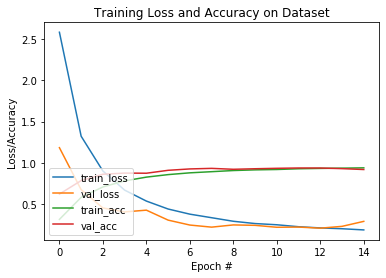

In [19]:
import matplotlib.pyplot as plt

n = np.arange(0, epochs)
plt.figure()
plt.plot(n, h.history["loss"], label="train_loss")
plt.plot(n, h.history["val_loss"], label="val_loss")
plt.plot(n, h.history["accuracy"], label="train_acc")
plt.plot(n, h.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()

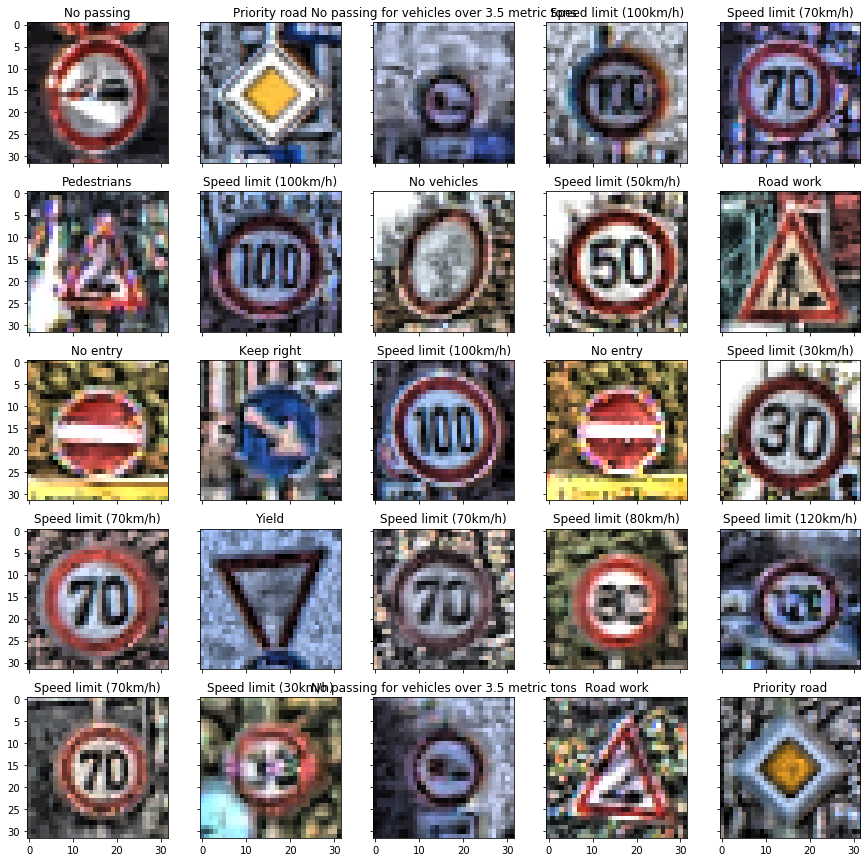

In [26]:
fig, axs = plt.subplots(5, 5)
fig.set_figheight(15)
fig.set_figwidth(15)

for i in range(5):
    for j in range(5):
        random_num = np.random.randint(0, len(x_test))
        img = x_test[random_num]
        axs[i, j].imshow(img)
        img = img.reshape(1, 32, 32, 3)
        res = model.predict(img)[0]
        axs[i, j].set_title(label_names[res.argmax()])
    
for ax in axs.flat:
    ax.label_outer()